In [1]:
!pip install astral
!pip install skforecast==0.13.0
!pip install shap
!pip install ipython-autotime
!pip install scikit-optimize
!pip install ipython-autotime
!pip install tensorflow keras-tuner

%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00
time: 384 µs (started: 2025-05-19 09:49:48 +00:00)


In [5]:
# Data processing
# ==============================================================================

import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
import seaborn as sns
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
# pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
# plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.model_selection import select_features
import shap
import time

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"Version skforecast: {skforecast.__version__}")
print(f"Version scikit-learn: {sklearn.__version__}")
print(f"Version lightgbm: {lightgbm.__version__}")
print(f"Version xgboost: {xgboost.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.5.0
Version xgboost: 2.1.4
time: 16.4 ms (started: 2025-05-19 09:50:32 +00:00)


In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error

time: 62.6 ms (started: 2025-05-19 09:50:39 +00:00)


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [7]:
from google.colab import files

# Tải tệp lên từ máy tính
uploaded = files.upload()

data = pd.read_excel('PV_data_preprocessing_then_resample.xlsx')

# Hiển thị dữ liệu
print(data.head())

Saving PV_data_preprocessing_then_resample.xlsx to PV_data_preprocessing_then_resample.xlsx
                 Time           P         Q           S   air temp   humidity  \
0 2022-07-01 07:00:00   40.250000  0.018500   40.233333  27.883333  88.000000   
1 2022-07-01 08:00:00   77.327273 -0.605091   77.354545  28.236364  87.800000   
2 2022-07-01 09:00:00  110.028571 -1.851000  110.514286  28.685714  86.128571   
3 2022-07-01 10:00:00   94.358333 -1.368917   94.433333  29.933333  81.041667   
4 2022-07-01 11:00:00  217.333333 -6.703333  217.333333  30.766667  79.633333   

   irrad global horizontal  irrad plant of array     pressure  rain fall  \
0               132.166667            121.866667  1001.000000        0.0   
1               215.000000            199.090909  1001.000000        0.0   
2               302.571429            281.828571  1001.000000        0.0   
3               255.666667            245.166667  1000.166667        0.0   
4               606.333333            586

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [8]:
# Chuyển cột 'time' thành kiểu datetime
data['Time'] = pd.to_datetime(data['Time'])

# Tạo các cột mới
data['month'] = data['Time'].dt.month        # Tháng
data['day'] = data['Time'].dt.day            # Ngày
data['weekday'] = data['Time'].dt.weekday    # Thứ (0: Thứ Hai, 6: Chủ Nhật)
data['hour'] = data['Time'].dt.hour          # Giờ

print(data)

                     Time           P         Q           S   air temp  \
0     2022-07-01 07:00:00   40.250000  0.018500   40.233333  27.883333   
1     2022-07-01 08:00:00   77.327273 -0.605091   77.354545  28.236364   
2     2022-07-01 09:00:00  110.028571 -1.851000  110.514286  28.685714   
3     2022-07-01 10:00:00   94.358333 -1.368917   94.433333  29.933333   
4     2022-07-01 11:00:00  217.333333 -6.703333  217.333333  30.766667   
...                   ...         ...       ...         ...        ...   
13181 2024-01-01 12:00:00   97.175000 -2.157500   97.187500  24.237500   
13182 2024-01-01 13:00:00   89.133333 -1.997778   89.177778  24.100000   
13183 2024-01-01 14:00:00   88.981818 -2.580000   89.027273  23.772727   
13184 2024-01-01 15:00:00   91.200000 -2.629000   91.280000  24.040000   
13185 2024-01-01 16:00:00   31.596364 -0.092545   31.550909  23.536364   

        humidity  irrad global horizontal  irrad plant of array     pressure  \
0      88.000000               

In [10]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(data['month'], cycle_length=12)
week_day_encoded = cyclical_encoding(data['weekday'], cycle_length=7)
hour_day_encoded = cyclical_encoding(data['hour'], cycle_length=24)



cyclical_features = pd.concat([
                        month_encoded,
                        week_day_encoded,
                        hour_day_encoded
                    ], axis=1)

data = pd.concat([data, cyclical_features], axis=1)
data.describe(include = 'all')

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



,Time,P,Q,S,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,...,month,day,weekday,hour,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
count,13186,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,4421.000000,...,13186.000000,13186.000000,13186.000000,13186.000000,13186.000000,1.318600e+04,13186.000000,13186.000000,1.318600e+04,1.318600e+04
mean,2023-04-01 23:30:00.000000256,161.595636,-3.261798,162.134536,28.645852,76.539686,424.010884,392.159738,1007.351846,0.000043,...,7.512817,15.748369,3.006522,11.500000,-0.210510,5.484722e-02,-0.003757,0.000857,7.325389e-05,-5.564186e-04
min,2022-07-01 07:00:00,5.110000,-40.425000,5.000000,14.333333,45.666667,17.300000,16.300000,992.400000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969,-1.000000e+00,-1.000000e+00
25%,2022-11-15 15:15:00,65.266667,-8.333333,65.575000,26.363636,71.609091,168.333333,155.166667,1003.000000,0.000000,...,5.000000,8.000000,1.000000,6.000000,-0.866025,-5.000000e-01,-0.781831,-0.900969,-7.071068e-01,-7.071068e-01
50%,2023-04-01 23:30:00,149.600000,-2.705000,150.150000,29.550000,77.333333,394.100000,355.833333,1006.416667,0.000000,...,8.000000,16.000000,3.000000,11.500000,-0.500000,-6.123234e-17,0.000000,-0.222521,1.224647e-16,-1.836970e-16
75%,2023-08-17 07:45:00,251.083333,-0.087500,251.181818,31.800000,82.425000,656.000000,595.166667,1011.363636,0.000000,...,10.000000,23.000000,5.000000,17.000000,0.500000,8.660254e-01,0.781831,0.623490,7.071068e-01,7.071068e-01
max,2024-01-01 16:00:00,378.666667,34.058333,378.916667,35.800000,94.000000,1070.666667,1048.666667,1029.000000,0.040000,...,12.000000,31.000000,6.000000,23.000000,1.000000,1.000000e+00,0.974928,1.000000,1.000000e+00,1.000000e+00
std,NaN,106.170111,9.989835,105.949432,3.966170,8.583751,282.620001,267.898320,5.796394,0.001003,...,3.301191,8.822245,2.002983,6.920276,0.673580,7.064272e-01,0.707107,0.707150,7.070836e-01,7.071834e-01


time: 247 ms (started: 2025-05-19 09:51:09 +00:00)


In [17]:
data = data.dropna()

time: 7.74 ms (started: 2025-05-19 09:55:12 +00:00)


In [18]:
exog_features = data.columns
elements_to_remove = ['day_str',	'year_month',	'distance' , 'PV','year','remove', 'Time', 'P','Q','S',
 'month',
 'week',
 'hour',
 'weekday',
 'day']
exog_features = [item for item in exog_features if item not in elements_to_remove]

time: 695 µs (started: 2025-05-19 09:55:12 +00:00)


In [19]:
exog_features

['air temp',
 'humidity',
 'irrad global horizontal',
 'irrad plant of array',
 'pressure',
 'rain fall',
 'temp 1',
 'temp 2',
 'temp 3',
 'wind direction',
 'wind speed',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos']

time: 2.52 ms (started: 2025-05-19 09:55:14 +00:00)


*************************************************************************
**********************************P********************************
*************************************************************************


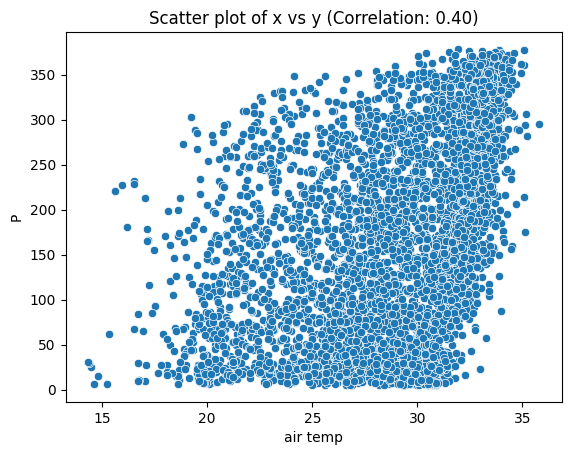

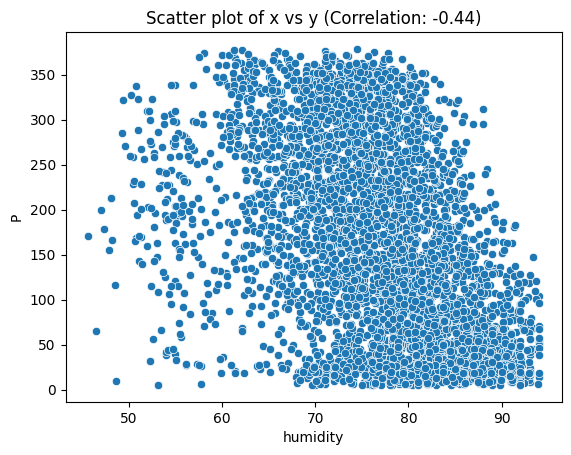

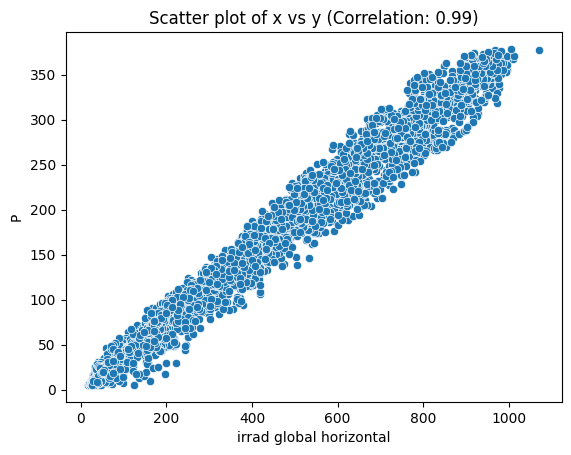

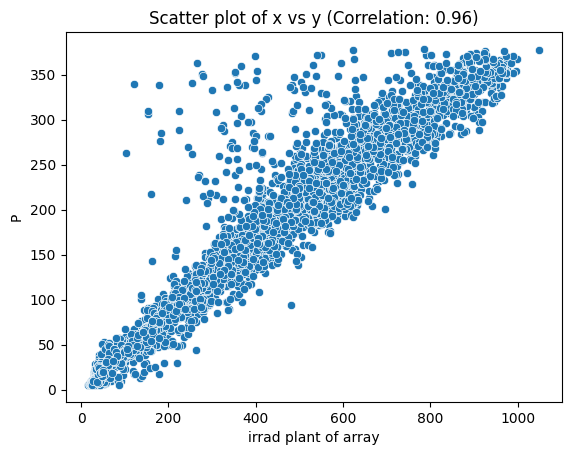

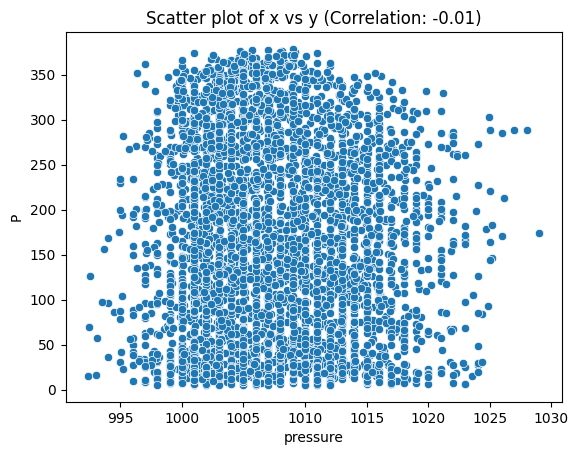

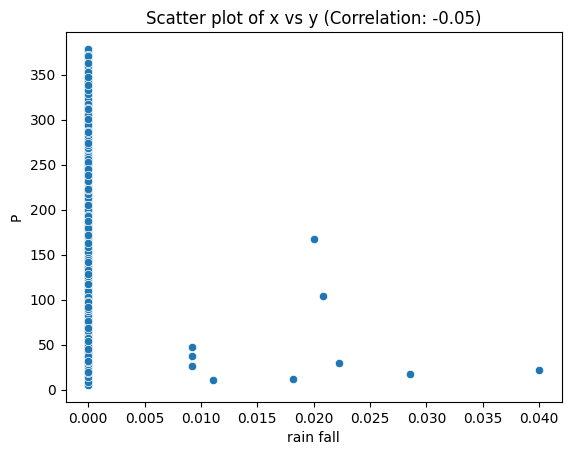

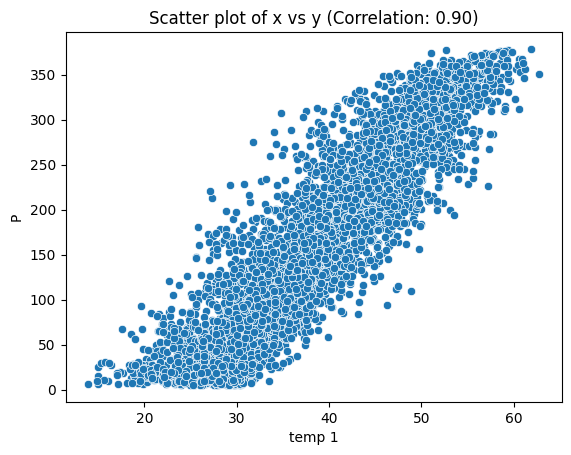

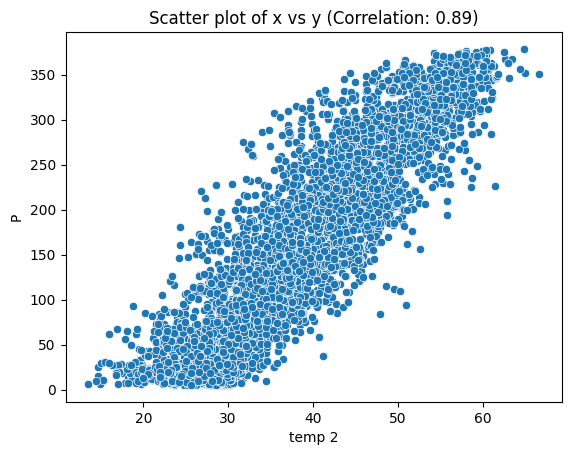

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide



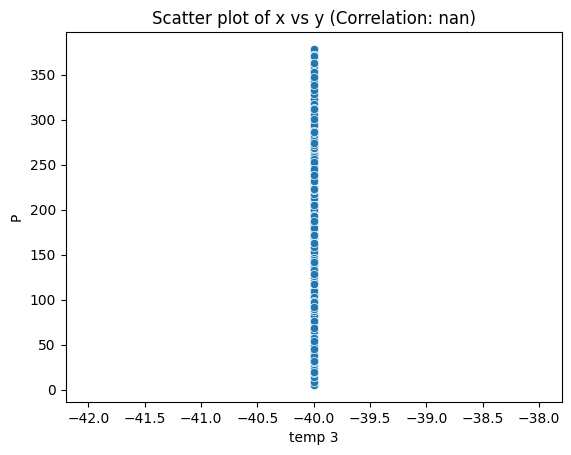

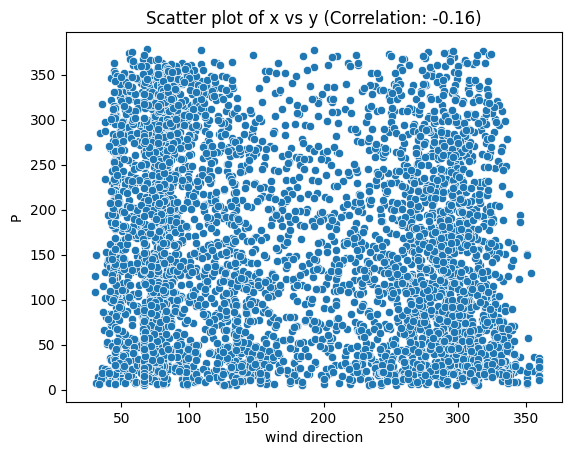

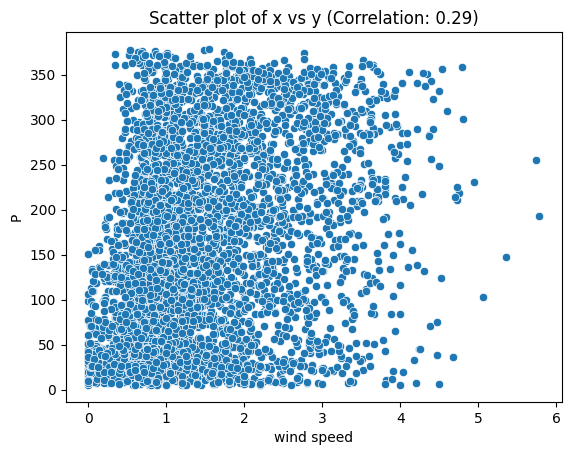

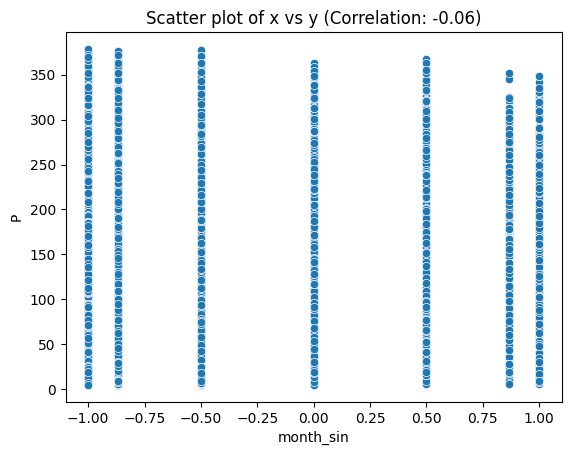

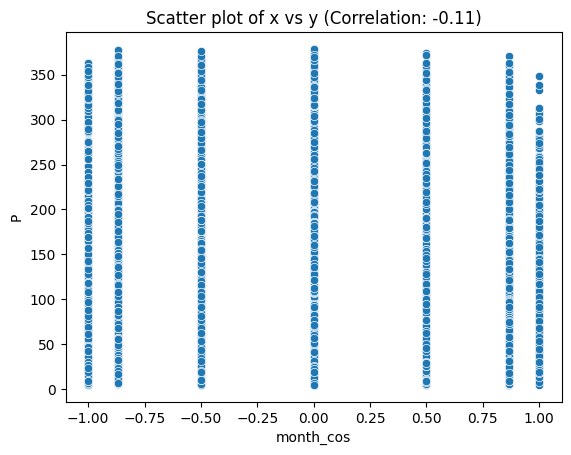

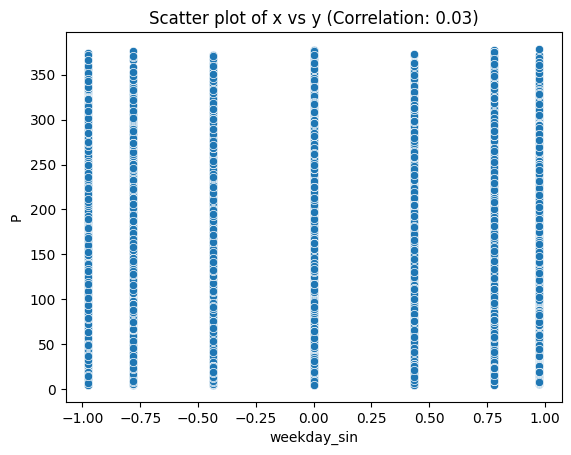

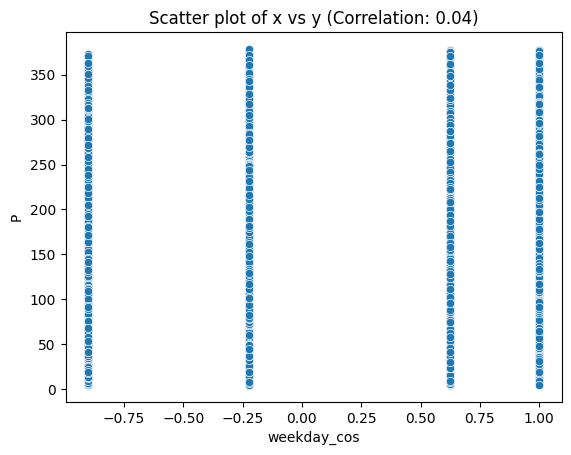

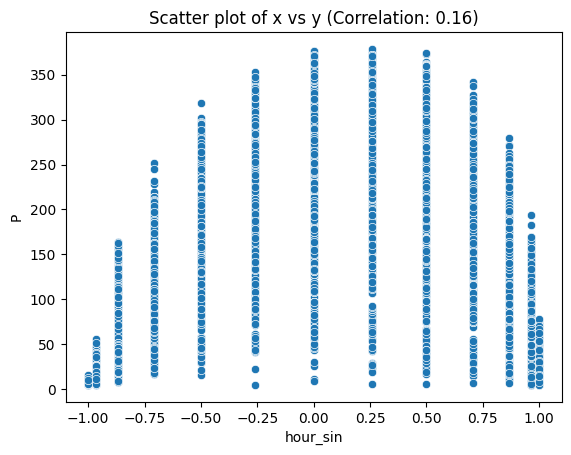

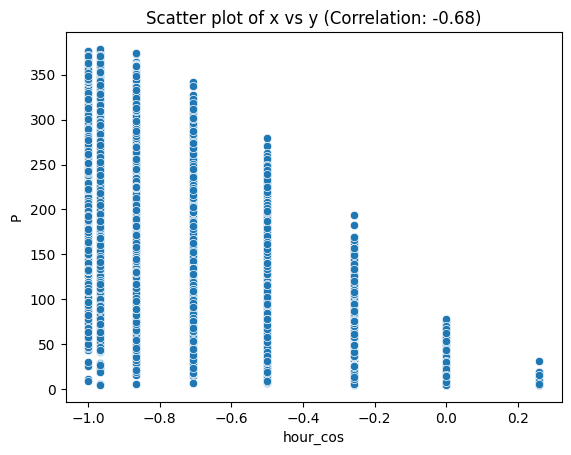

['air temp', 'humidity', 'irrad global horizontal', 'irrad plant of array', 'temp 1', 'temp 2', 'wind speed', 'hour_cos']
time: 4.17 s (started: 2025-05-19 09:55:15 +00:00)


In [20]:
target = 'P'
fe =[]
print("*************************************************************************")
print("**********************************"+target+"********************************")
print("*************************************************************************")
for i in exog_features:
    correlation = data[target].corr(data[i])
    # Vẽ biểu đồ
    sns.scatterplot(data=data, y=target, x=i)
    # Đặt tiêu đề với hệ số tương quan
    plt.title(f'Scatter plot of x vs y (Correlation: {correlation:.2f})')
    if abs(correlation)> 0.25: fe.append(i)
    plt.show()
print(fe)

# All

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Original split with ID tracking
X = data[exog_features]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)


# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 7.63 ms (started: 2025-05-19 09:55:19 +00:00)


In [22]:
start_time = time.time()
search_spaces  = {
        'n_neighbors'          : Integer( 5, 50),
         'weights': Categorical([ 'uniform', 'distance']),
        'leaf_size'  : Integer( 30, 50),
    }
initial_model = KNeighborsRegressor(
                )
initial_model.fit(X_train, y_train)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
# Regressor hyperparameters search space
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv=cv_strategy  # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(15), np.str_('distance')] before, using random point [np.int64(37), np.int64(39), 'uniform']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(16), np.str_('distance')] before, using random point [np.int64(35), np.int64(33), 'distance']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(16), np.str_('distance')] before, using random point [np.int64(49), np.int64(40), 'uniform']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(16), np.str_('distance')] before, using random point [np.int64(49), np.int64(23), 'uniform']

/usr/lo

Best parameters found:  OrderedDict([('leaf_size', 50), ('n_neighbors', 16), ('weights', 'distance')])
Best cross-validation score:  -11.722680099476879
306.4577987194061
time: 5min 6s (started: 2025-05-19 09:55:19 +00:00)


In [23]:
best_model = KNeighborsRegressor(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)
test_score = mean_absolute_error(y_test, y_test_pred2)
print("Validation set mean absolute error:", test_score)
print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.050577640533447266
Validation set mean absolute error: 11.196464992833796
Validation set mean absolute error: 11.196464992833796
161.53614263376298
161.00079669447524
161.00079669447524
time: 59 ms (started: 2025-05-19 10:01:28 +00:00)


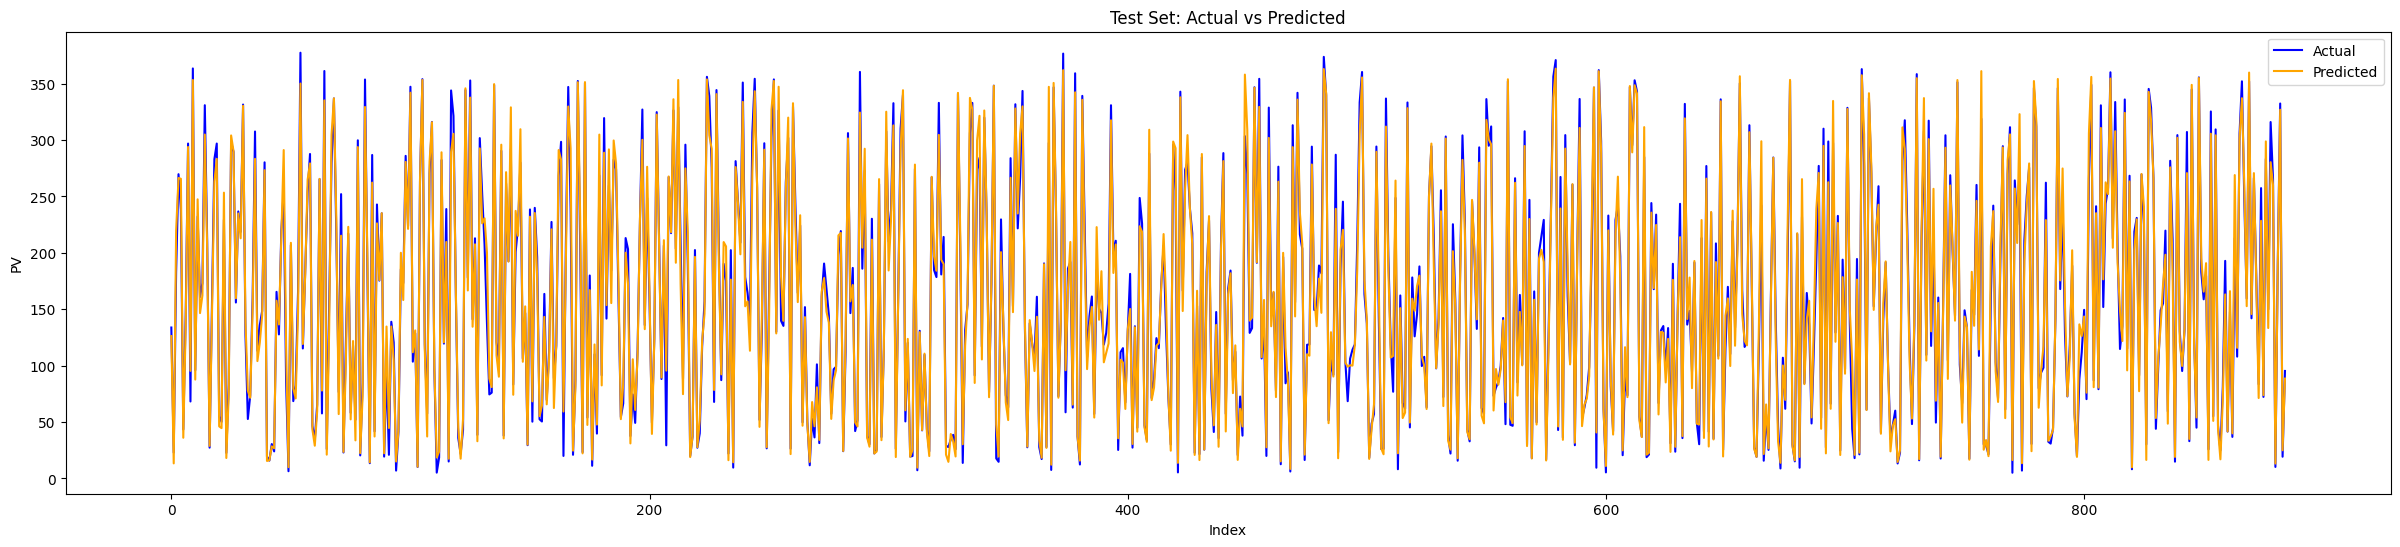

time: 383 ms (started: 2025-05-19 10:01:36 +00:00)


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 243.1649443087081
RMSE: 15.593746961801967
MAE: 11.196464992833796
MAPE: 12.048308405154545%
Relative MAE: 6.93124449444022%
Relative RMSE: 9.6534105046425%
time: 11.9 ms (started: 2025-05-19 10:01:44 +00:00)


In [26]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5_Results/KNN_PV_all_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Mounted at /content/drive
time: 16.8 s (started: 2025-05-19 10:02:29 +00:00)


In [28]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time

save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/PV_KNN_all.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.35 s (started: 2025-05-19 10:04:25 +00:00)


# Selected

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Original split with ID tracking
X = data[fe]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)


# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 25.8 ms (started: 2025-05-19 10:04:42 +00:00)


In [30]:
start_time = time.time()
search_spaces  = {
        'n_neighbors'          : Integer( 5, 50),
         'weights': Categorical([ 'uniform', 'distance']),
        'leaf_size'  : Integer( 30, 50),
    }
initial_model = KNeighborsRegressor(
                )
initial_model.fit(X_train, y_train)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
# Regressor hyperparameters search space
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv=cv_strategy  # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(17), np.str_('distance')] before, using random point [np.int64(48), np.int64(14), 'uniform']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(17), np.str_('distance')] before, using random point [np.int64(37), np.int64(25), 'uniform']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(17), np.str_('distance')] before, using random point [np.int64(31), np.int64(6), 'uniform']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50), np.int64(17), np.str_('distance')] before, using random point [np.int64(39), np.int64(21), 'distance']

/usr/loc

Best parameters found:  OrderedDict([('leaf_size', 50), ('n_neighbors', 17), ('weights', 'distance')])
Best cross-validation score:  -11.221050103457703
319.79160475730896
time: 5min 19s (started: 2025-05-19 10:04:50 +00:00)


In [31]:
best_model = KNeighborsRegressor(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)
test_score = mean_absolute_error(y_test, y_test_pred2)
print("Validation set mean absolute error:", test_score)
print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.017248153686523438
Validation set mean absolute error: 10.762223290208965
Validation set mean absolute error: 10.762223290208965
161.53614263376298
161.4655310751328
161.4655310751328
time: 26.3 ms (started: 2025-05-19 10:10:10 +00:00)


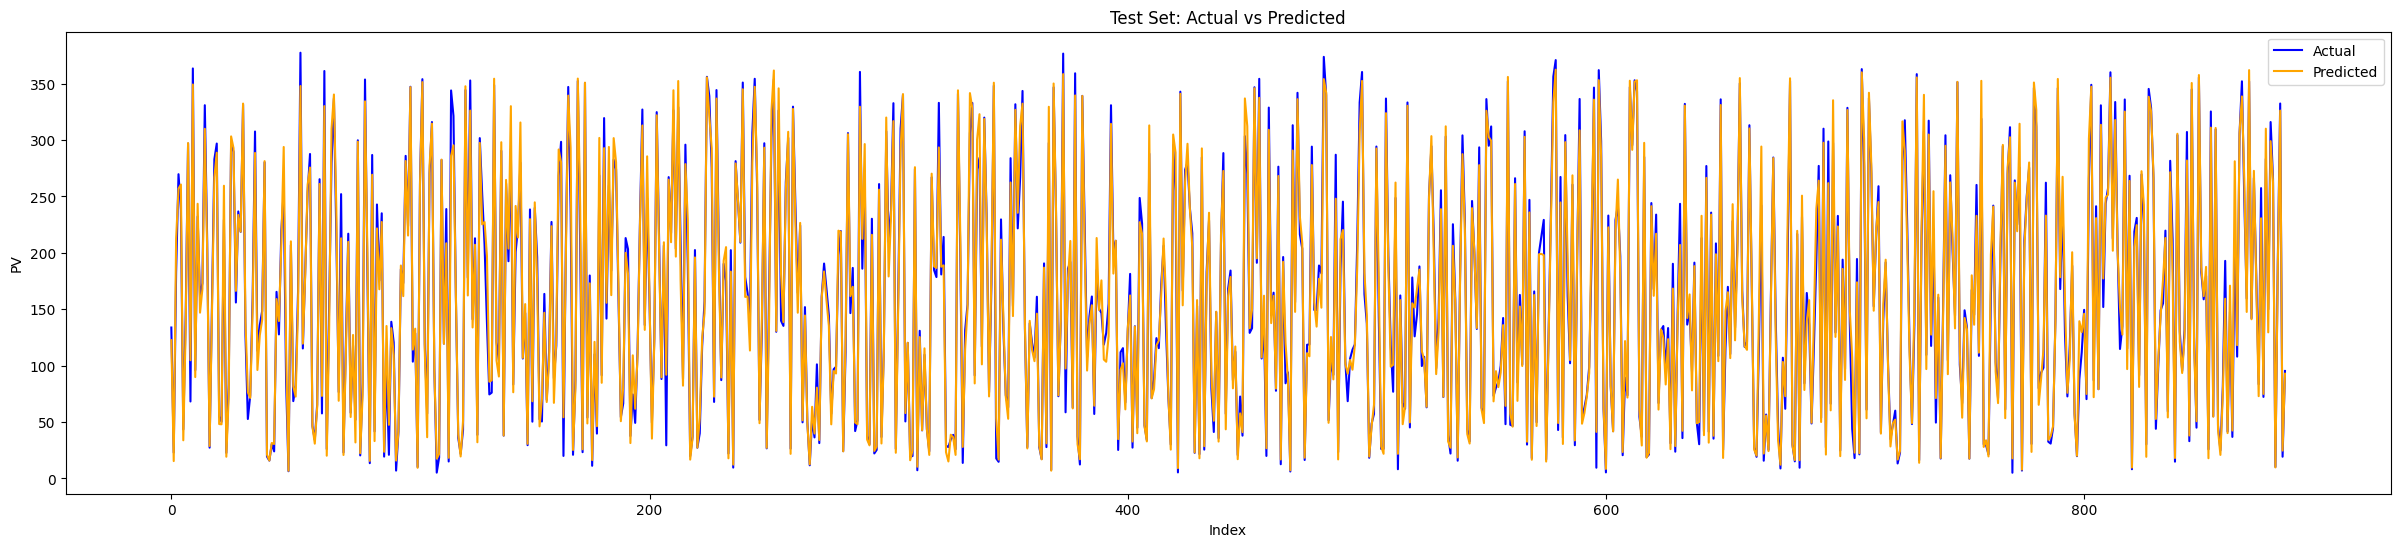

time: 378 ms (started: 2025-05-19 10:10:10 +00:00)


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 228.63441751359557
RMSE: 15.120661940325085
MAE: 10.762223290208965
MAPE: 11.306392382752403%
Relative MAE: 6.662424343392444%
Relative RMSE: 9.360544144357132%
time: 5.23 ms (started: 2025-05-19 10:10:11 +00:00)


In [34]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5_Results/KNN_PV_selected_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.41 s (started: 2025-05-19 10:10:57 +00:00)


In [35]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time

save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/PV_KNN_selected.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.54 s (started: 2025-05-19 10:11:03 +00:00)
